In [427]:
#!pip install statsmodels
#!pip install dython
from statsmodels.formula.api import ols

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import dython
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

### Multiclass Classification Model to predict what region a given MLB team is from

Using annual information that does not immediately give away what region a team is from, like attendance, games played, wins, etc, let's try to make a model that predicts a team's region based off a year's worth of data.

## Data Collection

We will look at 	[mlb_teams_data](https://www.openintro.org/data/index.php?data=mlb_teams), a subset of data on Major League Baseball teams from Lahman's Baseball Database.

In [428]:
# Gathering Data

filepath = 'datasets/Teams.csv'
df_teams = pd.read_csv(filepath, header = 0)

In [429]:
# retain relevant features for the model, ignoring data we don't want to include in the model

df_teams_red = df_teams.drop(['yearID', 'lgID', 'teamID', 'franchID',
                              'Rank', 'DivWin', 'WCWin', 'LgWin', 'name', 'park', 'BPF',
                              'PPF', 'teamIDBR', 'teamIDlahman45', 'teamIDretro'], axis = 1).copy()
df_teams_red

,divID,G,Ghome,W,L,WSWin,R,AB,H,2B,...,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance
0,NaN,31,NaN,20,10,NaN,401,1372,426,70,...,3,828,367,2,42,23,243,24,0.834,NaN
1,NaN,28,NaN,19,9,NaN,302,1196,323,52,...,1,753,308,6,28,22,229,16,0.829,NaN
2,NaN,29,NaN,10,19,NaN,249,1186,328,35,...,0,762,346,13,53,34,234,15,0.818,NaN
3,NaN,19,NaN,7,12,NaN,137,746,178,19,...,0,507,261,5,21,17,163,8,0.803,NaN
4,NaN,33,NaN,16,17,NaN,302,1404,403,43,...,0,879,373,7,42,22,235,14,0.840,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2980,C,162,81.0,90,72,N,706,5351,1303,261,...,50,4251,1234,152,608,1225,84,137,0.986,2102530.0
2981,E,162,81.0,100,62,N,857,5507,1336,288,...,42,4367,1264,184,436,1478,80,130,0.986,761072.0
2982,W,162,81.0,60,102,N,625,5405,1254,225,...,31,4273,1402,232,513,1239,83,146,0.986,2110258.0
2983,E,162,80.0,91,71,N,846,5476,1455,285,...,34,4216,1257,209,473,1468,90,122,0.984,805901.0


## Data Preparation

In [430]:
# Data preprocessing

# (remove NaN values)

# Remove data where the division ID does not exist

df_teams_no_NA = df_teams_red[df_teams_red['divID'].isna() == False].copy()
df_teams_no_NA

,divID,G,Ghome,W,L,WSWin,R,AB,H,2B,...,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance
1517,W,162,81.0,93,69,N,691,5460,1411,195,...,42,4335,1334,144,438,893,115,114,0.981,1458320.0
1518,E,162,81.0,109,53,N,779,5518,1465,234,...,36,4419,1194,117,498,897,101,145,0.984,1062069.0
1519,E,162,81.0,87,75,N,743,5494,1381,234,...,41,4398,1423,155,685,935,157,178,0.975,1833246.0
1520,W,163,81.0,71,91,N,528,5316,1221,151,...,39,4314,1294,126,517,885,135,164,0.978,758388.0
1521,W,162,81.0,68,94,N,625,5450,1346,210,...,25,4311,1470,146,564,810,122,163,0.981,589546.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2980,C,162,81.0,90,72,N,706,5351,1303,261,...,50,4251,1234,152,608,1225,84,137,0.986,2102530.0
2981,E,162,81.0,100,62,N,857,5507,1336,288,...,42,4367,1264,184,436,1478,80,130,0.986,761072.0
2982,W,162,81.0,60,102,N,625,5405,1254,225,...,31,4273,1402,232,513,1239,83,146,0.986,2110258.0
2983,E,162,80.0,91,71,N,846,5476,1455,285,...,34,4216,1257,209,473,1468,90,122,0.984,805901.0


In [431]:
# Unique values of categorical target variable

set(df_teams_no_NA['divID'])

{'C', 'E', 'W'}

In [432]:
# Let's count how many teams we have for each division

print(df_teams_no_NA[df_teams_no_NA['divID'] == 'W'].shape[0])
print(df_teams_no_NA[df_teams_no_NA['divID'] == 'C'].shape[0])
print(df_teams_no_NA[df_teams_no_NA['divID'] == 'E'].shape[0])

575
295
598


There appear to be three categories for a team's division, Central, East, and West. We have about twice as many teams within the East and West divisions as there teams in the Central division.

In [433]:
# Check for NA values

df_teams_no_NA.dropna(inplace = True)
df_teams_no_NA.isna().sum()

divID         0
G             0
Ghome         0
W             0
L             0
WSWin         0
R             0
AB            0
H             0
2B            0
3B            0
HR            0
BB            0
SO            0
SB            0
CS            0
HBP           0
SF            0
RA            0
ER            0
ERA           0
CG            0
SHO           0
SV            0
IPouts        0
HA            0
HRA           0
BBA           0
SOA           0
E             0
DP            0
FP            0
attendance    0
dtype: int64

No more NaN values

In [434]:
# Identify categorical data

print(dython.nominal.identify_nominal_columns(df_teams_no_NA))

# Encode this into numerical data

print(df_teams_no_NA['WSWin'].unique())
print(df_teams_no_NA['WSWin'].value_counts())

print(df_teams_no_NA['divID'].unique())
print(df_teams_no_NA['divID'].value_counts())

from sklearn.preprocessing import OneHotEncoder

# Convert column type to category
df_teams_no_NA['WSWin'] = df_teams_no_NA['WSWin'].astype('category')
enc = OneHotEncoder(drop = 'first')
enc_data = enc.fit_transform(df_teams_no_NA['WSWin'].values.reshape(-1,1)).toarray()
df_teams_no_NA['WSWin_enc'] = enc_data
df_WSWin_orig = df_teams_no_NA['WSWin'].copy()
df_teams_no_NA.drop(['WSWin'], axis = 1, inplace=True)

df_teams_no_NA['divID'] = df_teams_no_NA['divID'].astype('category')

#print(divID_enc)
df_teams_no_NA

['divID', 'WSWin']
['N' 'Y']
N    1365
Y      51
Name: WSWin, dtype: int64
['W' 'E' 'C']
E    576
W    555
C    285
Name: divID, dtype: int64


,divID,G,Ghome,W,L,R,AB,H,2B,3B,...,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance,WSWin_enc
1541,W,162,81.0,76,86,736,5546,1495,215,24,...,4292,1451,185,478,960,141,118,0.977,1078848.0,0.0
1542,E,162,81.0,108,54,792,5545,1424,213,25,...,4436,1317,139,469,941,117,148,0.981,1057069.0,1.0
1543,E,162,81.0,87,75,786,5535,1450,252,28,...,4339,1391,156,594,1003,156,131,0.974,1595278.0,0.0
1544,W,162,81.0,86,76,631,5532,1391,197,40,...,4387,1280,154,559,922,127,169,0.980,1077741.0,0.0
1545,W,162,84.0,56,106,633,5514,1394,192,20,...,4291,1554,164,556,762,165,187,0.975,495355.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2980,C,162,81.0,90,72,706,5351,1303,261,22,...,4251,1234,152,608,1225,84,137,0.986,2102530.0,0.0
2981,E,162,81.0,100,62,857,5507,1336,288,36,...,4367,1264,184,436,1478,80,130,0.986,761072.0,0.0
2982,W,162,81.0,60,102,625,5405,1254,225,24,...,4273,1402,232,513,1239,83,146,0.986,2110258.0,0.0
2983,E,162,80.0,91,71,846,5476,1455,285,13,...,4216,1257,209,473,1468,90,122,0.984,805901.0,0.0


['divID', 'G', 'Ghome', 'W', 'L', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'attendance', 'WSWin_enc']


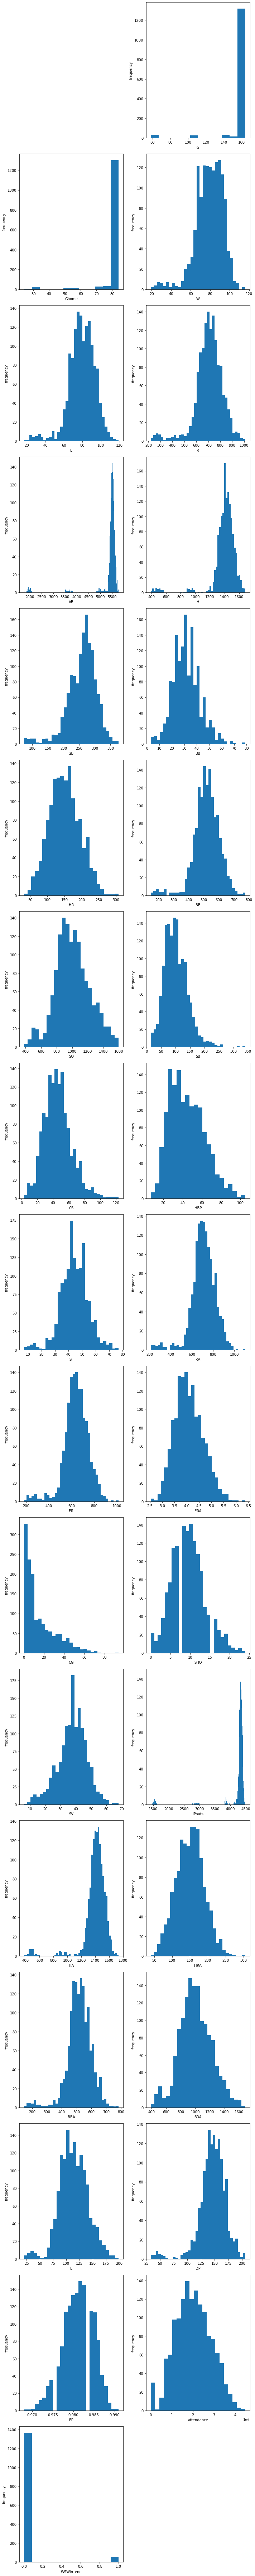

In [435]:
# Let's explore the distributions of the feature data

# configure max open warning
plt.rcParams.update({'figure.max_open_warning': 0})
cols = list(df_teams_no_NA.columns)
print(cols)

plt.figure(figsize=(10,100))
n = 1
for c in cols:
    if c != 'divID':
        plt.subplot((len(cols) - 1)//2 + 1, 2, n)
        plt.hist(df_teams_no_NA[c], bins = 'auto')
        plt.xlabel(c)
        plt.ylabel('frequency')
    n += 1

plt.tight_layout()
plt.show()

      divID    G  Ghome    W    L    R    AB     H   2B  3B  ...  IPouts  \
1541      0  162   81.0   76   86  736  5546  1495  215  24  ...    4292   
1542      2  162   81.0  108   54  792  5545  1424  213  25  ...    4436   
1543      2  162   81.0   87   75  786  5535  1450  252  28  ...    4339   
1544      0  162   81.0   86   76  631  5532  1391  197  40  ...    4387   
1545      0  162   84.0   56  106  633  5514  1394  192  20  ...    4291   

        HA  HRA  BBA   SOA    E   DP     FP  attendance  WSWin_enc  
1541  1451  185  478   960  141  118  0.977   1078848.0        0.0  
1542  1317  139  469   941  117  148  0.981   1057069.0        1.0  
1543  1391  156  594  1003  156  131  0.974   1595278.0        0.0  
1544  1280  154  559   922  127  169  0.980   1077741.0        0.0  
1545  1554  164  556   762  165  187  0.975    495355.0        0.0  

[5 rows x 33 columns]


<AxesSubplot:>

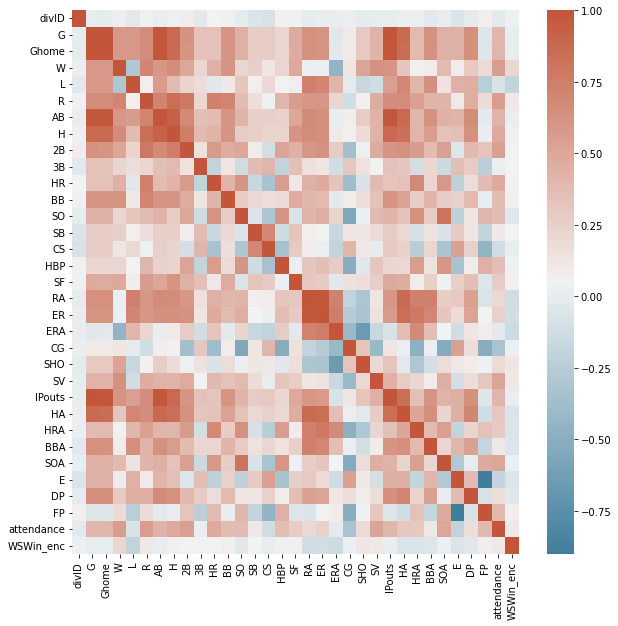

In [436]:
# check for multicollinearity (example: Wins, Losses, G, GHome...)

# Plot correlation matrix

df_temp = df_teams_no_NA.copy()

df_temp['divID'] = df_temp['divID'].map({'W': 0, 'C': 1, 'E': 2})
df_temp['divID'] = df_temp['divID'].astype('int64')
print(df_temp.head())
plt.figure(figsize=(10,10))
correlations = df_temp.corr()
sns.heatmap(correlations, cmap=sns.diverging_palette(230, 20, as_cmap=True))

In [437]:
# Univariate analysis for classification

from sklearn.feature_selection import SelectKBest, chi2

X = df_teams_no_NA.drop(['divID'], axis = 1).copy()
y = df_teams_no_NA['divID'].copy()

feature_selector = SelectKBest(chi2, k = "all")
fit = feature_selector.fit(X,y)

p_values = pd.DataFrame(fit.pvalues_)
scores = pd.DataFrame(fit.scores_)
input_names = pd.DataFrame(X.columns)
summary_stats = pd.concat([input_names, p_values, scores], axis = 1)
summary_stats.columns = ["input_variable", "p_value", "chi2_score"]
#summary_stats.sort_values(by = "p_value", inplace = True)
summary_stats

,input_variable,p_value,chi2_score
0,G,7.180841e-01,6.623371e-01
1,Ghome,8.076462e-01,4.272623e-01
2,W,2.981648e-05,2.084090e+01
3,L,1.591239e-03,1.288648e+01
4,R,7.355609e-39,1.756107e+02
5,AB,4.151888e-04,1.557355e+01
6,H,1.065759e-07,3.210882e+01
7,2B,3.198868e-120,5.502948e+02
8,3B,1.296105e-14,6.395366e+01
9,HR,1.574750e-133,6.115794e+02


In [438]:
# From the univariate test output, we can select only the features
# that do not exceed a threshold (let's say p=0.05)

p_value_threshold = 0.05
score_threshold = 5

selected_variables = summary_stats.loc[(summary_stats["chi2_score"] >= score_threshold) &
                                       (summary_stats["p_value"] <= p_value_threshold)]
selected_variables = selected_variables["input_variable"].tolist()
X_new_uni = X[selected_variables]
print(list(X_new_uni.columns))

['W', 'L', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'attendance']


Optimal number of features: 6


C:\Users\minat\anaconda3\envs\pyenv\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


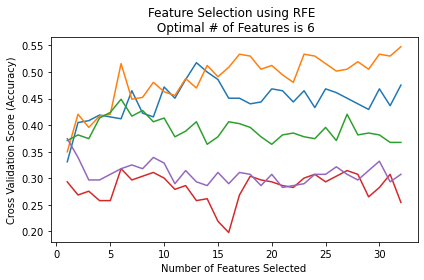

In [439]:
# Recursive Feature Elimination with Cross-Validation (RFECV)
# Iteratively removes variables with the weakest relationship with the output

# Also implements Cross-Validation, splitting the data and training on that
# splitted data

from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier

feature_selector = RFECV(DecisionTreeClassifier())
fit = feature_selector.fit(X, y)

optimal_feature_count = feature_selector.n_features_
print(f"Optimal number of features: {optimal_feature_count}")

X_new_RFE = X.loc[:, feature_selector.get_support()]

plt.plot(
    range(1, len(fit.grid_scores_) + 1),
    fit.grid_scores_
)
plt.ylabel("Cross Validation Score (Accuracy)")
plt.xlabel("Number of Features Selected")
plt.title(f"Feature Selection using RFE \n Optimal # of Features is {optimal_feature_count}")
plt.tight_layout() 
plt.show()

In [440]:
RFE_outcome = pd.DataFrame({
    'Feature' : [X.columns[c] for c in range(X.shape[1])],
    'Selected' : [fit.support_[c] for c in range(X.shape[1])],
    'Rank' : [fit.ranking_[c] for c in range(X.shape[1])]
}).sort_values(by=['Rank'])
RFE_outcome

,Feature,Selected,Rank
19,CG,True,1
27,E,True,1
30,attendance,True,1
14,HBP,True,1
13,CS,True,1
9,HR,True,1
7,2B,False,2
10,BB,False,3
11,SO,False,4
25,BBA,False,5


In [441]:
# We can now compare the results of the following for each feature:
# Distribution
# Correlation matrix
# Univariate analysis
# Recursive Feature Elimination

# We can start by removing the categorical WSWin_enc feature as it
# was ranked the worst by RFECV, was not selected in univariate
# testing, and has minimal correlation with the target divID

#X.drop(['WSWin_enc'], axis = 1, inplace = True)
#df_temp.drop(['WSWin_enc'], axis = 1, inplace = True)
# Now we are working with only numerical features

# First, standardize data

scale = StandardScaler()
X_scaled = pd.DataFrame(scale.fit_transform(X),
                        index = X.index,
                        columns = X.columns)

['G', 'Ghome', 'W', 'L', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'attendance', 'WSWin_enc']
Please enter a feature you want to analyze: G
Checking results for feature - G...


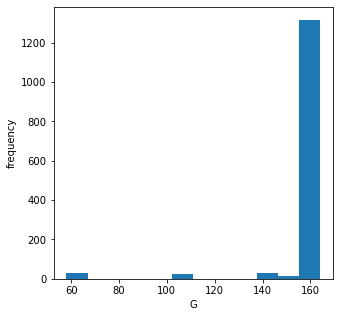

<Figure size 360x360 with 0 Axes>

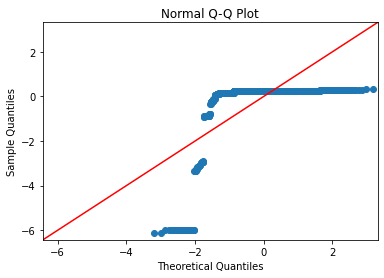

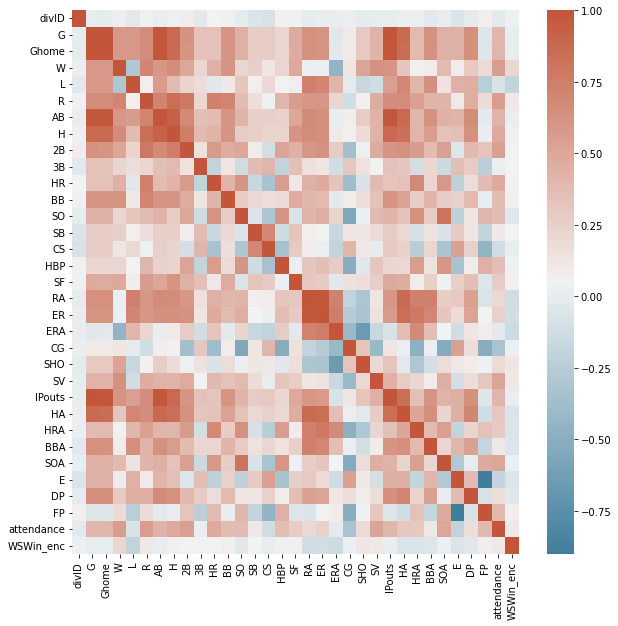

The feature G was NOT selected by univariate analysis.
Out of 32 features analyzed, 6 optimal features were found.
The feature G was NOT selected by RFECV out of all 32 features analyzed.


In [443]:
# Visualizing distributions and checking for normality using Q-Q plot
# (shows distribution of data against expected normal distribution)

print(list(X.columns))
c = input("Please enter a feature you want to analyze: ")
while c not in list(X.columns):
    c = input("Please try again (select one from the list above): ")
plt.figure(figsize=(5,5))
print(f"Checking results for feature - {c}...")
plt.hist(X[c], bins = 'auto')
plt.xlabel(c)
plt.ylabel('frequency')
plt.show()
plt.figure(figsize=(5,5))
sm.qqplot(X_scaled[c], line = '45')
plt.title('Normal Q-Q Plot')
plt.show()

# Correlation matrix section with heatmap

feature_corr = df_temp.corr()
#print(df_temp.dtypes)
plt.figure(figsize=(10,10))
sns.heatmap(feature_corr, cmap=sns.diverging_palette(230, 20, as_cmap=True))
plt.show()

# Univariate analysis result

if c in X_new_uni:
    print(f"The feature {c} was selected by univariate analysis.")
else:
    print(f"The feature {c} was NOT selected by univariate analysis.")

# RFE result

print(f"Out of {RFE_outcome.shape[0]} features analyzed, {optimal_feature_count} optimal features were found.")
if (RFE_outcome.loc[RFE_outcome['Feature'] == c]['Selected'] == True).values[0]:
    print(f"The feature {c} was selected by RFECV within the total {optimal_feature_count} optimal features.")
else:
    print(f"The feature {c} was NOT selected by RFECV out of all {RFE_outcome.shape[0]} features analyzed.")

<AxesSubplot:>

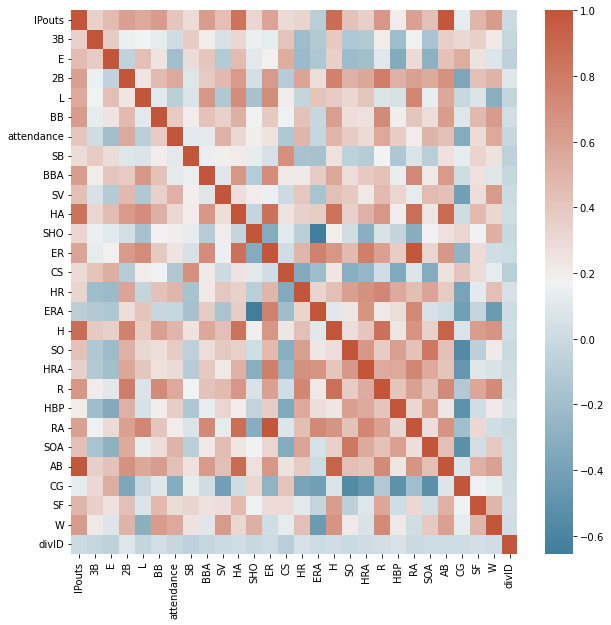

In [465]:
# Finally let's extract only the features we want to include in the model

extracted_features = list(set(list(X_new_uni.columns) + list(RFE_outcome[RFE_outcome['Selected'] == True]['Feature'].values))) # ignore duplicates
extracted_features.append(y.name)
plt.figure(figsize=(10,10))
feature_corr = df_temp[extracted_features].corr()
sns.heatmap(feature_corr, cmap=sns.diverging_palette(230, 20, as_cmap=True))

<AxesSubplot:>

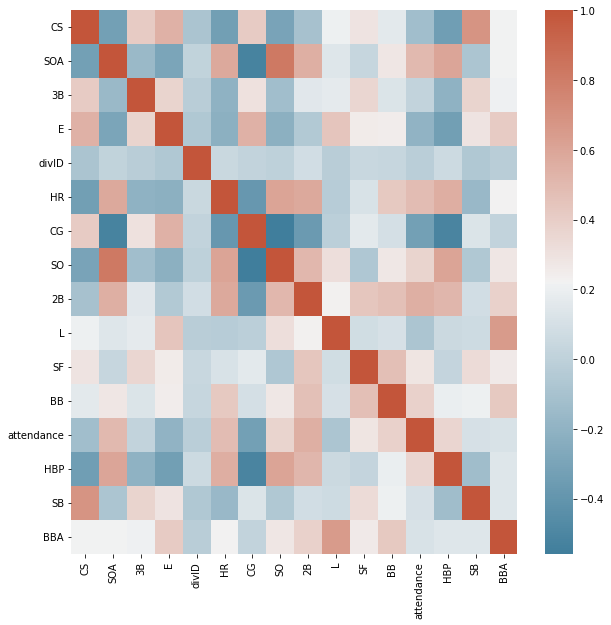

In [466]:
# Remove features with high multicollinearity

cols_to_remove = ['W', 'ER', 'SHO', 'H', 'ERA', 'R', 'RA', 'HRA', 'IPouts', 'HA', 'SV', 'AB', 'SOA']
extracted_features = list(set(extracted_features) - set(cols_to_remove))
plt.figure(figsize=(10,10))
feature_corr = df_temp[extracted_features].corr()
sns.heatmap(feature_corr, cmap=sns.diverging_palette(230, 20, as_cmap=True))

In [8]:
# Train Test Split

X = df_teams_no_NA.drop('divID', axis=1).copy()
y = df_teams_no_NA['divID'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
# Normalize training data

X_train_scaled = pd.DataFrame()

# save means and standard deviations when given a testing example

column_names = []
X_train_means = []
X_train_standard_deviations = []

for col in X_train.columns:
    column_names.append(col)
    X_train_scaled[col] = (X_train[col] - np.mean(X_train[col])) / np.std(X_train[col])
    X_train_means.append(np.mean(X_train[col]))
    X_train_standard_deviations.append(np.std(X_train[col]))
X_train_scaled

TypeError: Could not convert NNNNNYNNNNNNNNNNNNNNNNNNNNNNNNNNNYYNNNNNNNNNNNNNNNNNYNNNNNNNNYNNNNNNNNNNNNNNYNNNNNNNYNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNYNNNYNNNNNYNNNNNNNNNNNYNYYNNNNNNNYNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNYNNNNNNNNNNNNNNNNNYNNNNNNNNYNNNYNNNNNNYNNNNNNYNNNNNNNNNNNNNNNNNNNNNNNNNNNNYNNNNNNNNNYYNNNNNNNNNNNNYYNNNNNNNNNNNNNNNNYYNNNNYNNNNNNNNNNYNNNNYNNNNNNNNYNNNNNNNNNNNNNNNNYNNYNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNYNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNYNNNNNNNNNNNNNNNNNYNNNNNNNNNNNNNYNNNNNNNNNNNNNNNNNNNNNNNNYNNNNNNNNNNNNNNNNNYNNNNNNNNNYNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNYNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNYNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNYNNNNNNNNNYNNYNNNNNNNNNNNNNNNYNYNNYNNNNNNNNNNNYNNNNNNNNNNYNNNNNNNYNNNNNNNNNNNNNNNNNYYNNNNNNNNNNYNNNNNNNNNNNNNNNNNNNNNNNYNNNNNNNNNNNNNNNNNNNNNNNNNNNNYNYNNNNNNNNNNYNNNNNYNNNNNNNNNNNYNNNNNNNNNNNNYNNNNNYNNNNNNNNNNNNNNYNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNYNNNYNYNYNNNNNNYNNNNNNNNNNNNNNNNNNYNNNNNNNNNNNYNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNYNNYNNNNYNYNNNNNNNNNNNNYNNNNNNNNNNNNNNNNNNNNYNYNNNNNNNNNNNNNNNNYNYNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNYNNNNNNNNNNN to numeric

In [95]:
knn = KNeighborsClassifier(n_neighbors=7)
  
knn.fit(X_train_scaled, y_train)
  
# Calculate the accuracy of the model

# Normalize testing data

X_test_scaled = pd.DataFrame()

column_names = []
X_test_means = []
X_test_standard_deviations = []

for col in X_test.columns:
    column_names.append(col)
    X_test_scaled[col] = (X_test[col] - np.mean(X_test[col])) / np.std(X_test[col])
    means.append(np.mean(X_test[col]))
    standard_deviations.append(np.std(X_test[col]))

# Model Score

print(knn.score(X_test_scaled, y_test))

0.4897959183673469


In [136]:
# Predicting the division ID given an input of features

# testing with NaN value - have not done this yet

df_temp = X_test_scaled.iloc[0].to_frame().T
print(df_temp)
print(knn.predict(df_temp))

             G         R       AB         H        HR        CG        HA  \
2709  0.271901  0.117233  0.31642  0.529281 -1.113618 -0.680471 -0.099225   

          HRA  attendance  
2709 -0.17131    1.578372  
['W']


In [4]:
def predict_player_salary():
    

def predict hit zone () # area ball lands in (home run, left, right, foul, etc...)

IndentationError: expected an indented block after function definition on line 1 (2307934486.py, line 5)